In [1]:
%reset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For 3D Plots

#Required by Jupyter for inlining images
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
TL_BPM = pd.read_pickle('../Data/Beam1_TL_BPM.pkl')
BLM = pd.read_pickle('../Data/Beam1_BLM.pkl')

In [3]:
print('Num of Rows:')
print('BPM: ' + str(len(TL_BPM)))
print('BLM: ' + str(len(BLM)))

Num of Rows:
BPM: 1463
BLM: 1898


In [4]:
print('BPM Range: ' + str(min(TL_BPM['Time Stamp'])) + ' - ' + str(max(TL_BPM['Time Stamp'])))
print('BLM Range: ' + str(min(BLM['Time Stamp'])) + ' - ' + str(max(BLM['Time Stamp'])))

BPM Range: 1534475788.0 - 1540020799.0
BLM Range: 1534475807.77 - 1540020824.866


## Firstly, BPMs should be normalised since the BLM data is normalised

In [5]:
TL_BPM['MSE'] = (TL_BPM['MSE']-min(TL_BPM['MSE']))/(max(TL_BPM['MSE'])-min(TL_BPM['MSE']))

Find the Time Stamp in BPM that is closest to the first Time Stamp in BLM

In [6]:
start_time = BLM['Time Stamp'][0]
i = 0;
while TL_BPM['Time Stamp'][i] < start_time:
    print(TL_BPM['Time Stamp'][i])
    i = i + 1

1534475788.0


## Match TimeStamps

In [42]:
def match_datasets(df_1, col_index_1, df_2, col_index_2, epsilon):
    #col_indexes are the names of the columns to search (eg. 'Time Stamp')
    #Epsilon is the tolerance in seconds
    
    lenDf = len(df_1.columns) + len(df_2.columns)
    df = pd.DataFrame()#columns=list(range(0,lenDf)))
    
    matched = 0 #Number of elements matched
    dropped_df_1 = 0 #Number of elements dropped from df_1
    dropped_df_2 = 0 #Number of elements dropped from df_2
    
    #Ensure Dataframes are sorted by timestamp
    df_1 = df_1.sort_values(by=[col_index_1]).reset_index()
    df_2 = df_2.sort_values(by=[col_index_2]).reset_index()
    
    i = 0 #keeps track of index of df_1
    j = 0 #keeps track of index of df_2
    while i < len(df_1[col_index_1])-1 and j < len(df_2[col_index_2])-1:
        if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
            #Case 1:
            #Points matched
            matched = matched + 1
            #Add to new DataFrame:
            row = pd.Series(df_1.iloc[i,:].append(df_2.iloc[j,:])).to_frame().T
            df = df.append(row,ignore_index=True)
            #Increment both i and j
            i = i + 1
            j = j + 1
        #Lookahead on i
        elif df_1[col_index_1][i] < df_2[col_index_2][j]:
            #Case 2:
            i = i + 1
            dropped_df_1 = dropped_df_1 + 1 
            while df_1[col_index_1][i] < df_2[col_index_2][j]:
                if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
                    #Points Matched
                    matched = matched + 1
                    i = i + 1
                    j = j + 1
                    break
                else:
                    i = i + 1
                    dropped_df_1 = dropped_df_1 + 1
        elif df_1[col_index_1][i] > df_2[col_index_2][j]:
            #Case 3:
            j = j + 1
            dropped_df_2 = dropped_df_2 + 1 
            while df_1[col_index_1][i] > df_2[col_index_2][j]:
                if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
                    #Points Matched
                    matched = matched + 1
                    i = i + 1
                    j = j + 1
                    break
                else:
                    j = j + 1
                    dropped_df_2 = dropped_df_2 + 1
                
        
 
    print('Matched: ' + str(matched))
    print('Dropped from 1st df: ' + str(dropped_df_1))
    print('Dropped from 2nd df: ' + str(dropped_df_2))
    #return pd.DataFrame.from_records(rows)
    #print(rows)  
    
    return df

In [43]:
df = match_datasets(BLM,'Time Stamp',TL_BPM,'Time Stamp', 50)

Matched: 1462
Dropped from 1st df: 433
Dropped from 2nd df: 0


In [44]:
df.head()

,index,Time Stamp,Reading 1,Reading 2,Reading 3,index,Time Stamp,1,2,3,...,10,11,12,13,14,15,16,17,18,MSE
0,0.0,1.534476e+09,0.032946,0.046330,0.037706,0.0,1.534476e+09,-0.114,-0.035,-1.063,...,-0.879,0.341,0.049,-1.138,-1.413,0.088,-1.494,-0.411,-0.820,0.000000
1,1.0,1.534476e+09,0.054595,0.075554,0.061253,1.0,1.534476e+09,-0.062,-0.134,-0.786,...,-0.837,0.301,0.101,-1.127,-1.339,0.204,-1.436,-0.358,-0.765,0.013231
2,2.0,1.534476e+09,0.031869,0.044786,0.036302,2.0,1.534476e+09,-0.146,0.082,-1.066,...,-0.774,0.346,-0.035,-1.098,-1.444,0.073,-1.414,-0.433,-0.730,0.005537
3,3.0,1.534476e+09,0.057333,0.069524,0.059613,3.0,1.534476e+09,-0.104,-0.037,-0.872,...,-0.762,0.311,0.023,-1.143,-1.347,0.132,-1.396,-0.379,-0.668,0.008761
4,4.0,1.534477e+09,0.045874,0.058032,0.048874,4.0,1.534477e+09,-0.014,-0.008,-0.859,...,-0.740,0.250,0.025,-0.971,-1.447,0.268,-1.489,-0.406,-0.696,0.011608


Fix Duplicate Columns

In [48]:
cols = []
count = 1
for column in df.columns:
    if column == 'Time Stamp':
        cols.append('Time Stamp '+str(count))
        count+=1
        continue
    cols.append(column)
df.columns = cols  

Text(0,0.5,'TL_BPM')

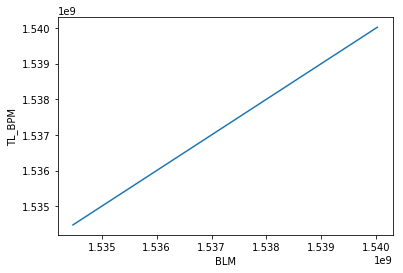

In [49]:
plt.figure()
plt.plot(df['Time Stamp 1'], df['Time Stamp 2'])
plt.xlabel('BLM')
plt.ylabel('TL_BPM')

Text(0,0.5,'TL_BPM MSE')

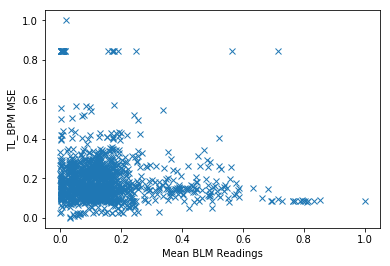

In [54]:
plt.figure()
plt.plot(df['Reading 1'], df['MSE'],'x')
plt.xlabel('BLM Reading')
plt.ylabel('TL_BPM MSE')